# Comparing Random vs Non Random data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(12,5)})
%load_ext autoreload
%autoreload 2

In [2]:
import re
# from tqdm import tqdm
from tqdm.notebook import trange, tqdm

In [3]:
import sys
import os
sys.path.append(os.path.abspath('../modules'))
from lnds import longest_non_decreasing_subsequence as lnds
from hard_rules import denoised_fraction, version_serializtion
from lots import longest_sequence, plot_intervals

In [4]:
data = pd.read_parquet("../Data/random_10k.parquet")

In [5]:
data = data[data["maid"]=='7']

## Filtering
1. Non houses 
2. Cookies with mixed constant 
3. Cookies which are assigned to a house which they do not apepar in

In [6]:
data = data[~data['is_hh']]

In [7]:
unique_values_per_cookie = data.groupby(["hh_id", "iiqid"])[["timestamp", "brand", "model", "os", "browser", "advertisedbrowser"]].nunique()

In [8]:
unique_values_per_cookie["sum"] = unique_values_per_cookie.iloc[:,1:].sum(axis=1)

In [9]:
equal_5 = unique_values_per_cookie[unique_values_per_cookie["sum"]==5]
more_than_5 = unique_values_per_cookie[unique_values_per_cookie["sum"]>5]

In [10]:
mixed_iiqids = more_than_5.index.get_level_values(level=1).to_list()

In [11]:
data = data[~data['iiqid'].isin(mixed_iiqids)]

In [12]:
misplaced_series = ~data.groupby('iiqid')['is_house_ip_or_source_ip'].any()
misplaced_iiqids = misplaced_series[misplaced_series].index.values

In [13]:
data = data[~data['iiqid'].isin(misplaced_iiqids)]

## Creating relevant tables
- Random pairs
- Cookies time data
- Cookies version noise data

In [14]:
const = ['hh_id',"brand", "model", "os", "browser"]

In [15]:
def has_multiple_ua(house):
    user_agents = house[const].drop_duplicates()
    return len(user_agents) >= 2

In [16]:
filtered = data.groupby('hh_id', observed=True).filter(has_multiple_ua)

In [17]:
filtered_grouped_by = filtered.groupby(const, observed=True)
filtered_grouped = filtered_grouped_by.agg({'iiqid': ['nunique', pd.Series.mode]})

In [18]:
filtered_grouped.columns = ['nunique','iiqid']
filtered_grouped = filtered_grouped[filtered_grouped['nunique'] == 1].drop('nunique', axis=1)

In [19]:
grouped = filtered_grouped.iloc[:,0].drop_duplicates()

In [20]:
grouped = grouped.groupby(level=0, observed=True).filter(lambda g: g.nunique() > 1)

In [21]:
two_from_each_houe = grouped.groupby(observed=True, level=0, group_keys=False).apply(lambda g: g.sample(2))

In [22]:
trial_data = two_from_each_houe.reset_index()#.drop('hh_id', axis=1).reset_index()

In [23]:
trial_pairs = trial_data.groupby('hh_id')['iiqid'].agg(['min', 'max'])
trial_pairs.columns = ['first','second']

In [24]:
cookie_time = data.groupby('iiqid')['time'].agg(['min', 'max'])

In [25]:
cookie_time['interval'] = (cookie_time['max'] - cookie_time['min']).apply(lambda t: t.days)

In [26]:
noises = data.groupby('iiqid').apply(denoised_fraction)

In [27]:
noises = noises.rename('noise')

### A single pair

- Time interval first
- Time interval second
- Time between end first and start second(maybe after remove outliers)
- Time interval we looked at (can check options)
- Number of points min
- Number of points max
- UA version error
- Overlap errors that we calculate

In [28]:
random_cookie_1 = np.random.choice(data['iiqid'].unique())
random_cookie_2 = np.random.choice(data['iiqid'].unique())

In [29]:
size1 = len(data[data['iiqid']==random_cookie_1])
size2 = len(data[data['iiqid']==random_cookie_2])

In [30]:
single_row = pd.DataFrame({'id1': [random_cookie_1], 'id2': [random_cookie_2], 
              'min_size': min(size1, size2), 'max_size':max(size1, size2)})

In [31]:
single_row = single_row.merge(cookie_time, left_on='id1', right_index=True)
single_row = single_row.merge(cookie_time, left_on='id2', right_index=True, 
                              suffixes=('_id1', '_id2'))

In [32]:
single_row = single_row.merge(noises, left_on='id1', right_index=True)
single_row = single_row.merge(noises, left_on='id2', right_index=True, 
                              suffixes=('_id1', '_id2'))

In [33]:
single_row

,id1,id2,min_size,max_size,min_id1,max_id1,interval_id1,min_id2,max_id2,interval_id2,noise_id1,noise_id2
0,mxyNGzsloe,XARMhd5IiG,3,26,2022-12-10 14:16:52.057,2023-02-18 12:25:18.759,69,2022-12-29 19:51:16.129,2023-02-21 00:22:09.494,53,1.0,1.0


### Random Data

In [34]:
noise_of_pairs = {'merge_noise': [], 'size_0': [], 'size_1': [], 'first' :[], 'second': []}

for house in tqdm(trial_pairs.index):
    iiqid_0, iiqid_1 = trial_pairs.loc[house].values
    pair_data = filtered[(filtered['hh_id']==house) 
                     & ((filtered['iiqid']==iiqid_0) 
                        | (filtered['iiqid']==iiqid_1))].copy()
    pair_data.sort_values(by='time', inplace=True)
    serialize_id = {iiqid_0: 0, iiqid_1: 1}
    
    s, inds = lnds(pair_data['iiqid'].apply(lambda x: serialize_id[x]).values)
    not_inds = [i for i in range(len(pair_data)) if i not in inds]
    
    noise_of_pairs['merge_noise'].append(1 - len(s) / len(pair_data))
    noise_of_pairs['size_0'].append(sum(pair_data['iiqid']==iiqid_0))
    noise_of_pairs['size_1'].append(sum(pair_data['iiqid']==iiqid_1))
    noise_of_pairs['first'].append(iiqid_0)
    noise_of_pairs['second'].append(iiqid_1)
noise_of_pairs_df = pd.DataFrame(noise_of_pairs)

  0%|          | 0/1330 [00:00<?, ?it/s]

In [35]:
random_trial_data = noise_of_pairs_df.merge(cookie_time, left_on='first', right_index=True)
random_trial_data = random_trial_data.merge(cookie_time, left_on='second', right_index=True, 
                              suffixes=('_0', '_1'))

In [36]:
random_trial_data = random_trial_data.merge(noises, left_on='first', right_index=True)
random_trial_data = random_trial_data.merge(noises, left_on='second', right_index=True, 
                              suffixes=('_0', '_1'))

In [37]:
random_trial_data['min_size'] = random_trial_data[['size_0','size_1']].min(axis=1)
random_trial_data['max_size'] = random_trial_data[['size_0','size_1']].max(axis=1)

In [38]:
random_trial_data = random_trial_data.rename(columns={'min_0': 'start_0', 'max_0': 'end_0',
                                  'min_1': 'start_1', 'max_1': 'end_1',
                                  'noise_0': 'vers_clean_0', 'noise_1': 'vers_clean_1'})

In [39]:
random_trial_data['min_interval'] = random_trial_data[['interval_0', 'interval_1']].min(axis=1)
random_trial_data['max_interval'] = random_trial_data[['interval_0', 'interval_1']].max(axis=1)

random_trial_data['min_vers_clean'] = random_trial_data[['vers_clean_0', 'vers_clean_1']].min(axis=1)
random_trial_data['max_vers_clean'] = random_trial_data[['vers_clean_0', 'vers_clean_1']].max(axis=1)

In [40]:
random_trial_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
merge_noise,1330.0,0.124428,0.140349,0.000000,0.01,0.066667,0.20,0.5
size_0,1330.0,41.236090,85.622388,1.000000,2.00,11.000000,46.00,1441.0
size_1,1330.0,42.440602,83.669554,1.000000,2.00,12.000000,45.75,1148.0
interval_0,1330.0,35.024812,33.248796,0.000000,0.00,30.000000,69.00,88.0
interval_1,1330.0,35.186466,33.209323,0.000000,0.00,28.000000,70.00,88.0
vers_clean_0,1330.0,0.998362,0.013371,0.666667,1.00,1.000000,1.00,1.0
vers_clean_1,1330.0,0.997990,0.015659,0.666667,1.00,1.000000,1.00,1.0
min_size,1330.0,12.289474,24.763312,1.000000,1.00,3.000000,12.75,275.0
max_size,1330.0,71.387218,109.415292,1.000000,11.00,35.500000,87.75,1441.0
min_interval,1330.0,17.519549,25.428310,0.000000,0.00,0.000000,31.00,87.0


<AxesSubplot: >

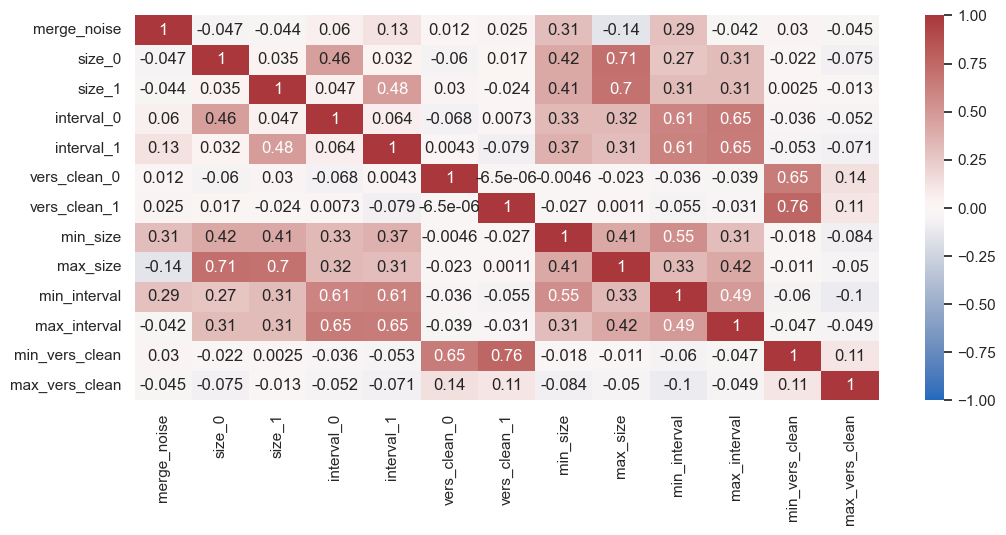

In [41]:
sns.heatmap(data=random_trial_data.corr(numeric_only=True), annot=True, vmin=-1, vmax=1, cmap='vlag')

In [42]:
# mins = random_trial_data[features].min()
# maxs = random_trial_data[features].max()

In [43]:
# random_trial_data.loc[(random_trial_data[features] >= thresholds).all(axis=1), 'merge_noise'].mean()

In [44]:
# matrix = []
# for s in range(1, 30):
#     row = []
#     for i in range(14):
#         row.append(random_trial_data.loc[(random_trial_data[features] >= [s, i, 0.5]).all(axis=1), 
#                                          'merge_noise'].mean())
#     matrix.append(row)

From all the pairs which 
1. Both cookies have more instances than some threshold
2. Both cookies are lived more than somethreshold
3. Both cookies have version consistency more than some threshold  

What fraction have the the merging noise is less than some threshold?

In [45]:
features = ['min_size', 'min_interval', 'min_vers_clean']
target = 'merge_noise'

In [46]:
# features
thresholds = [3, 7, 0.5]
noise_thresh = 0.02

In [47]:
total_above_thresh = random_trial_data.loc[(random_trial_data[features] >= thresholds).all(axis=1)]
good_aobve_thresh = total_above_thresh[total_above_thresh['merge_noise'] < noise_thresh]
print(len(good_aobve_thresh)/len(total_above_thresh))

0.0710172744721689


In [48]:
matrix = []
for s in range(1, 30):
    row = []
    for i in range(14):
        total_above_thresh = random_trial_data.loc[(random_trial_data[features] >= [s, i, 0.5]).all(axis=1)]
        good_aobve_thresh = total_above_thresh[total_above_thresh['merge_noise'] < noise_thresh]
        row.append(len(good_aobve_thresh)/len(total_above_thresh))
    matrix.append(row)

<AxesSubplot: >

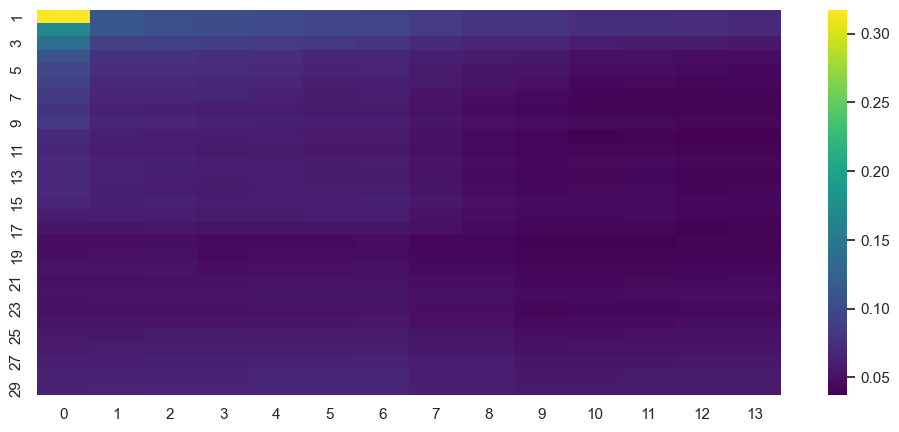

In [49]:
sns.heatmap(data=pd.DataFrame(matrix, columns=range(14), index=range(1,30)), 
            cmap='viridis')

## Non-Random Data

In [50]:
more_than_one_cooke = data.groupby(const, observed=True).filter(lambda g: g['iiqid'].nunique() > 1)

In [51]:
def pick_two_random(group):
    return np.random.choice(group.unique(), size=2, replace=False)

pairs_series = more_than_one_cooke.groupby(const, observed=True)['iiqid'].agg(pick_two_random)

In [52]:
brothers_paris = pd.DataFrame.from_dict(
        dict(zip(range(len(pairs_series)), pairs_series.values))).\
        transpose()
brothers_paris.columns = ['first','second']

In [53]:
i = 0
iiqid_0, iiqid_1 = trial_pairs.iloc[i].values
print(iiqid_0, iiqid_1)

MONnq4JN4P T9zwT1qFhM


In [54]:
noise_of_pairs2 = {'merge_noise': [], 'size_0': [], 'size_1': [], 'first' :[], 'second': []}

for i in tqdm(brothers_paris.index):
    iiqid_0, iiqid_1 = brothers_paris.iloc[i].values
    pair_data = more_than_one_cooke[((more_than_one_cooke['iiqid']==iiqid_0) 
                        | (more_than_one_cooke['iiqid']==iiqid_1))].copy()
    pair_data.sort_values(by='time', inplace=True)
    serialize_id = {iiqid_0: 0, iiqid_1: 1}
    
    s, inds = lnds(pair_data['iiqid'].apply(lambda x: serialize_id[x]).values)
    not_inds = [i for i in range(len(pair_data)) if i not in inds]
    
    noise_of_pairs2['merge_noise'].append(1 - len(s) / len(pair_data))
    noise_of_pairs2['size_0'].append(sum(pair_data['iiqid']==iiqid_0))
    noise_of_pairs2['size_1'].append(sum(pair_data['iiqid']==iiqid_1))
    noise_of_pairs2['first'].append(iiqid_0)
    noise_of_pairs2['second'].append(iiqid_1)
noise_of_pairs_df2 = pd.DataFrame(noise_of_pairs2)

  0%|          | 0/2627 [00:00<?, ?it/s]

In [55]:
random_trial_data2 = noise_of_pairs_df2.merge(cookie_time, left_on='first', right_index=True)
random_trial_data2 = random_trial_data2.merge(cookie_time, left_on='second', right_index=True, 
                              suffixes=('_0', '_1'))

In [56]:
random_trial_data2 = random_trial_data2.merge(noises, left_on='first', right_index=True)
random_trial_data2 = random_trial_data2.merge(noises, left_on='second', right_index=True, 
                              suffixes=('_0', '_1'))

In [57]:
random_trial_data2['min_size'] = random_trial_data2[['size_0','size_1']].min(axis=1)
random_trial_data2['max_size'] = random_trial_data2[['size_0','size_1']].max(axis=1)

In [58]:
random_trial_data2 = random_trial_data2.rename(columns={'min_0': 'start_0', 'max_0': 'end_0',
                                  'min_1': 'start_1', 'max_1': 'end_1',
                                  'noise_0': 'vers_clean_0', 'noise_1': 'vers_clean_1'})

In [59]:
random_trial_data2['min_interval'] = random_trial_data2[['interval_0', 'interval_1']].min(axis=1)
random_trial_data2['max_interval'] = random_trial_data2[['interval_0', 'interval_1']].max(axis=1)

random_trial_data2['min_vers_clean'] = random_trial_data2[['vers_clean_0', 'vers_clean_1']].min(axis=1)
random_trial_data2['max_vers_clean'] = random_trial_data2[['vers_clean_0', 'vers_clean_1']].max(axis=1)

In [60]:
random_trial_data2.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
merge_noise,2627.0,0.148593,0.153832,0.000000,0.009091,0.096774,0.25,0.5
size_0,2627.0,36.583175,80.408375,1.000000,2.000000,9.000000,36.00,1573.0
size_1,2627.0,36.825657,92.379759,1.000000,2.000000,10.000000,36.00,2974.0
interval_0,2627.0,28.160259,31.120393,0.000000,0.000000,15.000000,55.00,88.0
interval_1,2627.0,28.070803,31.234018,0.000000,0.000000,14.000000,56.00,88.0
vers_clean_0,2627.0,0.998390,0.016499,0.500000,1.000000,1.000000,1.00,1.0
vers_clean_1,2627.0,0.997642,0.020338,0.571429,1.000000,1.000000,1.00,1.0
min_size,2627.0,12.840502,27.198812,1.000000,1.000000,3.000000,13.00,590.0
max_size,2627.0,60.568329,114.544202,1.000000,8.000000,26.000000,73.00,2974.0
min_interval,2627.0,15.321279,23.888648,0.000000,0.000000,0.000000,24.50,88.0


In [61]:
# random_trial_data2.corr(numeric_only=True)['merge_noise'][1:].plot.bar()

<AxesSubplot: >

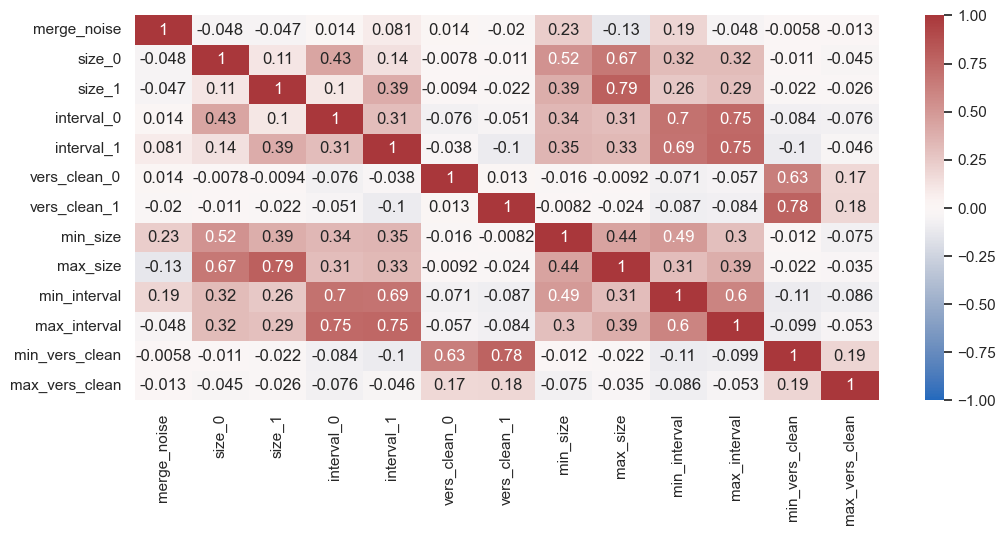

In [62]:
sns.heatmap(data=random_trial_data2.corr(numeric_only=True), annot=True, vmin=-1, vmax=1, cmap='vlag')

In [63]:
features = ['min_size', 'min_interval', 'min_vers_clean']
target = 'merge_noise'

In [64]:
matrix2 = []
for s in range(1, 30):
    row = []
    for i in range(14):
        total_above_thresh = random_trial_data2.loc[(random_trial_data2[features] >= [s, i, 0.5]).all(axis=1)]
        good_aobve_thresh = total_above_thresh[total_above_thresh['merge_noise'] < noise_thresh]
        row.append(len(good_aobve_thresh)/len(total_above_thresh))
    matrix2.append(row)

<AxesSubplot: >

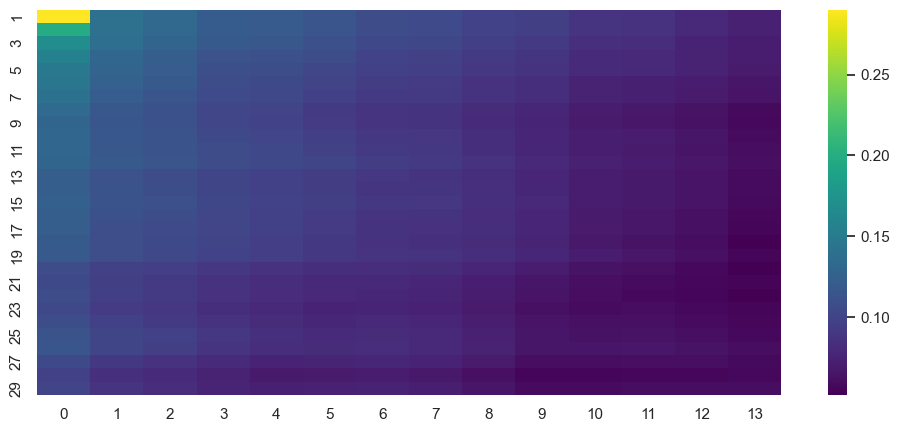

In [65]:
sns.heatmap(data=pd.DataFrame(matrix2, columns=range(14), index=range(1,30)), 
            cmap='viridis')

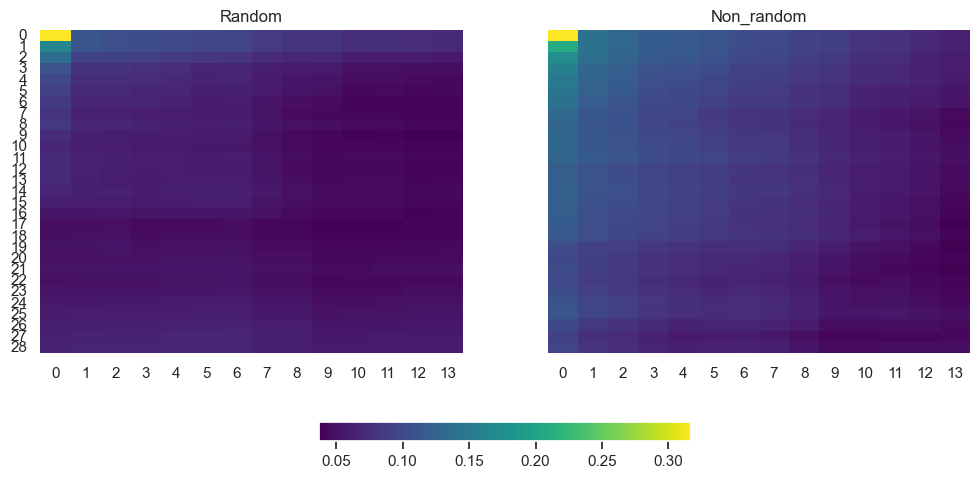

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

heatmap1 = sns.heatmap(matrix, cmap='viridis', ax=ax[0], cbar=False)
ax[0].set_title('Random')

heatmap2 = sns.heatmap(matrix2, cmap='viridis', ax=ax[1], cbar=False)
ax[1].set_title('Non_random')

# Add a shared colorbar to the plot
mappable = heatmap1.get_children()[0]
plt.colorbar(mappable, ax = ax,orientation = 'horizontal', shrink=0.4)

In [67]:
matrix_part = [m[:10] for m in matrix[:10]]
matrix2_part = [m[:10] for m in matrix2[:10]]

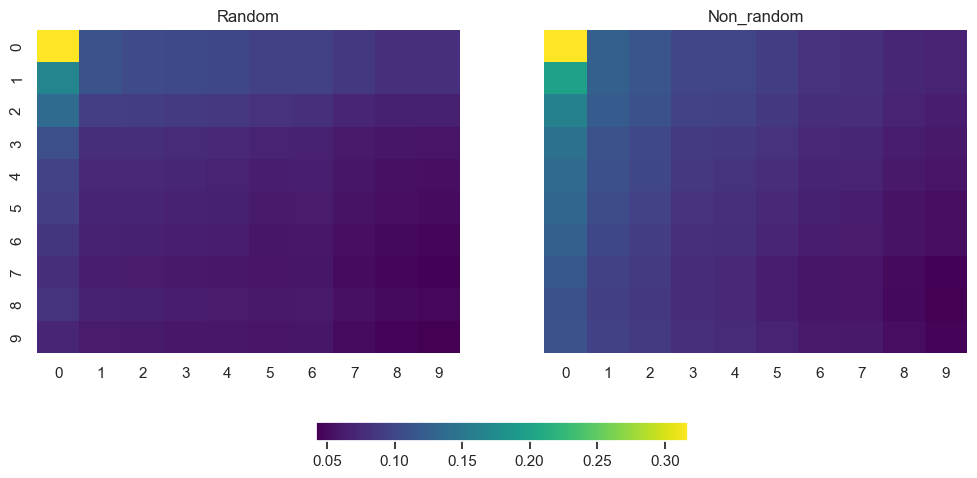

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

heatmap1 = sns.heatmap(matrix_part, cmap='viridis', ax=ax[0], cbar=False)
ax[0].set_title('Random')

heatmap2 = sns.heatmap(matrix2_part, cmap='viridis', ax=ax[1], cbar=False)
ax[1].set_title('Non_random')

# Add a shared colorbar to the plot
mappable = heatmap1.get_children()[0]
plt.colorbar(mappable, ax = ax,orientation = 'horizontal', shrink=0.4)

In [69]:
s = 20
i = 14
len(random_trial_data.loc[(random_trial_data[features] >= [s, i, 0.5]).all(axis=1)])

204

In [70]:
matrix_test = []
for s in range(1, 30):
    row = []
    for i in range(14):
        total_above_thresh = random_trial_data2.loc[(random_trial_data2[features] >= [s, i, 0.5]).all(axis=1)]
        good_aobve_thresh = total_above_thresh[total_above_thresh['merge_noise'] < noise_thresh]
        row.append(len(total_above_thresh))
    matrix_test.append(row)

In [71]:
min(min(matrix_test))

249

Text(0.5, 1.0, 'Non-Random')

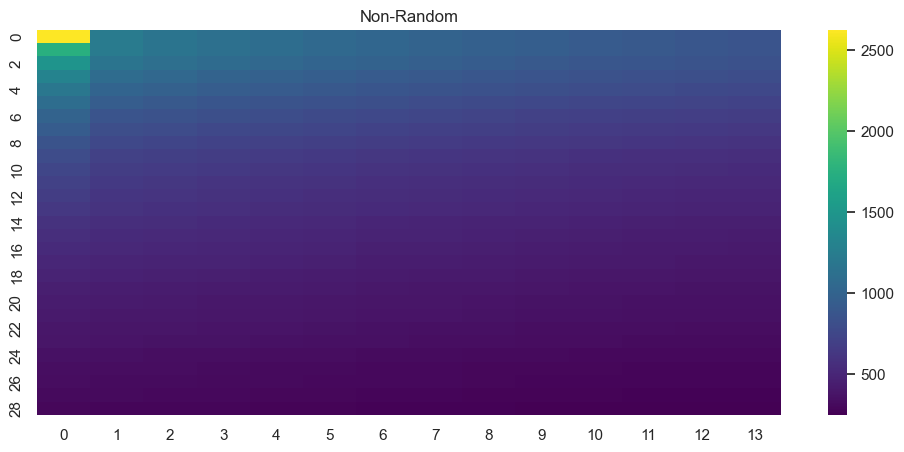

In [72]:
sns.heatmap(matrix_test, cmap='viridis')
plt.title("Non-Random")

## GridSearch

In [73]:
def good_cookies_above_thresh(df, min_interval, min_size, min_vers_clean, merge_noise):
    total_above_thresh = df.loc[(df[features] >= [min_size, min_interval, min_vers_clean]).all(axis=1)]
    good_aobve_thresh = total_above_thresh[total_above_thresh['merge_noise'] < merge_noise]
    return len(good_aobve_thresh)/len(total_above_thresh)

In [74]:
# Define the ranges of parameter values to sample from
param_ranges = {
    'min_interval': np.arange(0, 14),
    'min_size': np.arange(1, 10),
    'min_vers_clean': np.linspace(0.5, 1, 10),
    'merge_noise': np.linspace(0, 0.2, 11)
}

# Set the number of random samples to generate
num_samples = 5000

# Initialize variables to keep track of the best parameter values and the largest difference
best_diff_params = None
best_ratio_params = None
largest_difference = None
largest_ratio = None

# Loop over all random samples of parameter values
for i in tqdm(range(num_samples)):
    # Sample random values for each parameter within the specified ranges
    param_values = {
        param_name: np.random.choice(param_range) for param_name, param_range in param_ranges.items()
    }
    
    # Apply the function to both dataframes with the current parameter values
    result1 = good_cookies_above_thresh(random_trial_data, **param_values)
    result2 = good_cookies_above_thresh(random_trial_data2, **param_values)
    
    # Compute the difference between the results
    difference = abs(result2 - result1)
    if result2 > 0:
        ratio = 1 - result1/result2
    else:
        ratio = 0
    
    # Check if the current parameter values give a larger difference than the previous best
    if largest_difference is None or difference > largest_difference:
        largest_difference = difference
        best_diff_params = param_values

    if largest_ratio is None or ratio > largest_ratio:
        largest_ratio = ratio
        best_ratio_params = param_values

# Print the best parameter values and the largest difference
print("Best difference parameters:", {k: round(v, 3) for k,v in best_diff_params.items()})
print("Largest difference:", largest_difference)
print("Best ratio parameters:", {k: round(v, 3) for k,v in best_ratio_params.items()})
print("Largest ratio:", largest_ratio)

  0%|          | 0/5000 [00:00<?, ?it/s]

Best difference parameters: {'min_interval': 0, 'min_size': 1, 'min_vers_clean': 0.611, 'merge_noise': 0.06}
Largest difference: 0.07458864552686062
Best ratio parameters: {'min_interval': 8, 'min_size': 7, 'min_vers_clean': 1.0, 'merge_noise': 0.02}
Largest ratio: 0.4959557258407833


In [75]:
result_diff = {k: round(v, 3) for k,v in best_diff_params.items()}
result_diff['random'] = good_cookies_above_thresh(random_trial_data, **best_diff_params)
result_diff['non-random'] = good_cookies_above_thresh(random_trial_data2, **best_diff_params)
pd.DataFrame(result_diff, index=['best'])

,min_interval,min_size,min_vers_clean,merge_noise,random,non-random
best,0,1,0.611,0.06,0.484962,0.410374


In [76]:
result_diff = {k: round(v, 3) for k,v in best_ratio_params.items()}
result_diff['random'] = good_cookies_above_thresh(random_trial_data, **best_ratio_params)
result_diff['non-random'] = good_cookies_above_thresh(random_trial_data2, **best_ratio_params)
pd.DataFrame(result_diff, index=['best'])

,min_interval,min_size,min_vers_clean,merge_noise,random,non-random
best,8,7,1.0,0.02,0.049383,0.097973


In [77]:
# Define the ranges of parameter values to sample from
param_ranges = {
    'min_interval': np.arange(0, 14),
    'min_size': np.arange(1, 10),
    'min_vers_clean': np.linspace(0.5, 1, 10),
    'merge_noise': np.linspace(0, 0.2, 11)
}

# Set the number of random samples to generate
num_samples = 5000

# Initialize an empty dataframe to store the results
results_df = pd.DataFrame(columns=list(param_ranges.keys()) + ['random', 'non-random', 'difference', 'ratio'])

# Loop over all random samples of parameter values
for i in tqdm(range(num_samples)):
    # Sample random values for each parameter within the specified ranges
    param_values = {
        param_name: np.random.choice(param_range) for param_name, param_range in param_ranges.items()
    }
    
    # Apply the function to both dataframes with the current parameter values
    result1 = good_cookies_above_thresh(random_trial_data, **param_values)
    result2 = good_cookies_above_thresh(random_trial_data2, **param_values)
    
    # Compute the difference between the results
    difference = abs(result2 - result1)
    if result2 > 0:
        ratio = 1 - result1/result2
    else:
        ratio = 0.
    
    # Create a new dataframe with the current parameter values and the resulting difference
    row_df = pd.DataFrame({**param_values, 'random': result1, 'non-random': result2,
                           'difference': difference, 'ratio': ratio}, index=[0])
    
    # Concatenate the new dataframe to the results dataframe
    results_df = pd.concat([results_df, row_df], ignore_index=True)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [78]:
results_df['min_interval'] = results_df['min_interval'].astype('int')
results_df['min_size'] = results_df['min_size'].astype('int')

In [79]:
results_df.sort_values(by='ratio', ascending=False).head(10)

,min_interval,min_size,min_vers_clean,merge_noise,random,non-random,difference,ratio
2040,1,8,1.000000,0.02,0.063063,0.129851,0.066788,0.514342
1641,1,7,1.000000,0.02,0.068681,0.133333,0.064652,0.484890
2142,1,9,1.000000,0.02,0.067093,0.127796,0.060703,0.475000
3358,2,8,0.944444,0.02,0.061069,0.113134,0.052065,0.460209
4057,2,8,0.944444,0.02,0.061069,0.113134,0.052065,0.460209
807,2,6,1.000000,0.02,0.070496,0.129973,0.059477,0.457612
788,7,8,1.000000,0.02,0.052980,0.097345,0.044365,0.455750
3860,7,8,1.000000,0.02,0.052980,0.097345,0.044365,0.455750
3810,1,8,0.666667,0.02,0.063260,0.115906,0.052646,0.454211
869,1,8,0.611111,0.02,0.063260,0.115906,0.052646,0.454211


<AxesSubplot: >

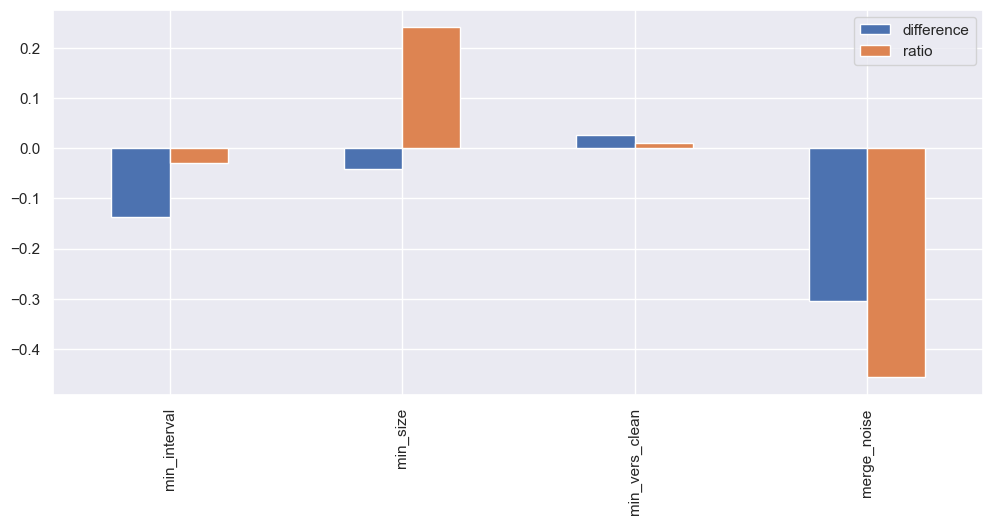

In [80]:
results_df.corr()[['difference', 'ratio']][:4].plot.bar()

## Restrict by longest living cookie

### LOTS

In [81]:
df = cookie_time.head(15).reset_index().sort_values(by='min')

In [82]:
longest_sequence(cookie_time.sample(15).reset_index(), name_str='iiqid', start_str='min', end_str='max')

['0VlnZyjM1y']

In [83]:
shots = cookie_time[(5 < cookie_time['interval']) & (cookie_time['interval'] < 20)].reset_index()

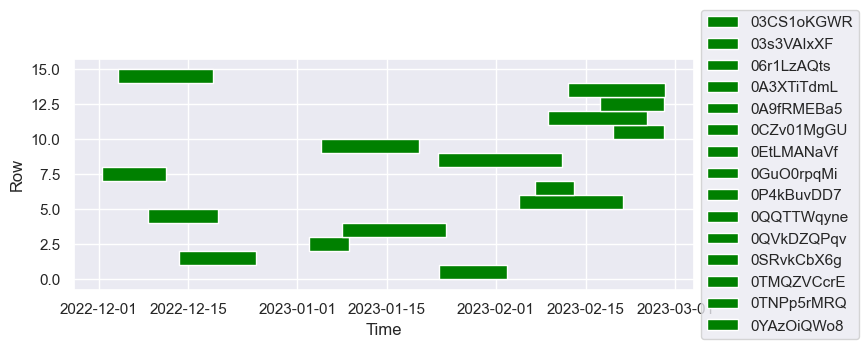

In [84]:
# df = cookie_time.sample(15).reset_index()
df = shots.head(15)
chosen_ids = longest_sequence(df, name_str='iiqid', start_str='min', end_str='max')
plot_intervals(df, name_str='iiqid', start_str='min', end_str='max', color='green')

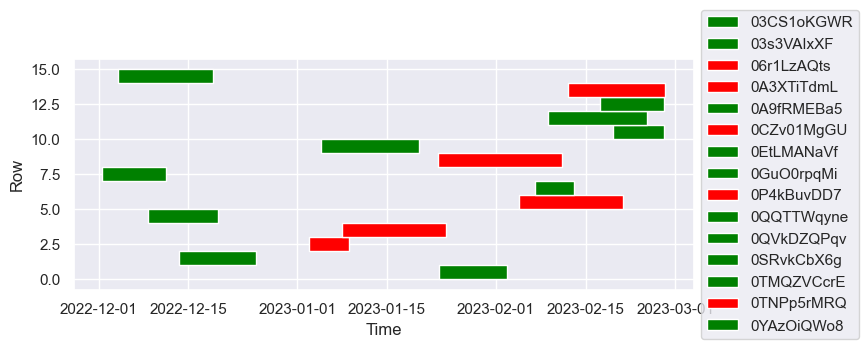

In [85]:
# df = cookie_time.sample(15).reset_index()
df = shots.head(15)
chosen_ids = longest_sequence(df, name_str='iiqid', start_str='min', end_str='max')
plot_intervals(df, name_str='iiqid', start_str='min', end_str='max', color='green', highlight_ids=chosen_ids, highlight_color='red')

### Filtering

In [86]:
const = ['hh_id',"brand", "model", "os", "browser"]

In [87]:
cookies_data = cookie_time.reset_index().merge(data[const+['iiqid']], on='iiqid', how='left')

In [88]:
longest_cookie_per_home = cookies_data.groupby('hh_id').apply(lambda h: h.loc[h['interval'].idxmax(), 'iiqid'])

In [89]:
longest_cookie_per_home.name = 'iiqid'

In [90]:
longest_cookie_per_home_data = pd.merge(longest_cookie_per_home.reset_index(), cookies_data, 
                                        on=['hh_id', 'iiqid'], how='inner')
longest_cookie_per_home_data = longest_cookie_per_home_data.drop_duplicates()

In [91]:
cookie_vs_longest = cookies_data.merge(longest_cookie_per_home_data, on='hh_id', suffixes=[None, '_longest'])

In [92]:
filtered_cookies = cookie_vs_longest[(((cookie_vs_longest['min'] < cookie_vs_longest['min_longest'])
                                       & (cookie_vs_longest['max'] > cookie_vs_longest['min_longest']))
                                      | ((cookie_vs_longest['min'] > cookie_vs_longest['min_longest'])
                                         & (cookie_vs_longest['min'] < cookie_vs_longest['max_longest'])))]

In [93]:
filtered_cookies = filtered_cookies.drop_duplicates()

In [94]:
filtered_data = data[data['iiqid'].isin(filtered_cookies['iiqid'].values.tolist())]

#### Random

In [95]:
def has_multiple_ua(house):
    user_agents = house[const].drop_duplicates()
    return len(user_agents) >= 2

In [96]:
filtered = filtered_data.groupby('hh_id', observed=True).filter(has_multiple_ua)

In [97]:
filtered_grouped_by = filtered.groupby(const, observed=True)
filtered_grouped = filtered_grouped_by.agg({'iiqid': ['nunique', pd.Series.mode]})

In [98]:
filtered_grouped.columns = ['nunique','iiqid']
filtered_grouped = filtered_grouped[filtered_grouped['nunique'] == 1].drop('nunique', axis=1)

In [99]:
grouped = filtered_grouped.iloc[:,0].drop_duplicates()

In [100]:
grouped = grouped.groupby(level=0, observed=True).filter(lambda g: g.nunique() > 1)

In [101]:
two_from_each_houe = grouped.groupby(observed=True, level=0, group_keys=False).apply(lambda g: g.sample(2))

In [102]:
trial_data = two_from_each_houe.reset_index()#.drop('hh_id', axis=1).reset_index()

In [103]:
trial_pairs = trial_data.groupby('hh_id')['iiqid'].agg(['min', 'max'])
trial_pairs.columns = ['first','second']

In [104]:
noise_of_pairs = {'merge_noise': [], 'size_0': [], 'size_1': [], 'time_diff': [], 'first' : [], 'second': []}

for house in tqdm(trial_pairs.index):
    iiqid_0, iiqid_1 = trial_pairs.loc[house].values
    pair_data = filtered[(filtered['hh_id']==house) 
                     & ((filtered['iiqid']==iiqid_0) 
                        | (filtered['iiqid']==iiqid_1))].copy()
    pair_data.sort_values(by='time', inplace=True)
    iiqid_0_start, iiqid_1_start = pair_data.groupby('iiqid')['time'].agg('min').values
    pair_time_diff = abs(iiqid_0_start - iiqid_1_start)
    serialize_id = {iiqid_0: 0, iiqid_1: 1}
    
    s, inds = lnds(pair_data['iiqid'].apply(lambda x: serialize_id[x]).values)
    not_inds = [i for i in range(len(pair_data)) if i not in inds]
    
    noise_of_pairs['merge_noise'].append(1 - len(s) / len(pair_data))
    noise_of_pairs['size_0'].append(sum(pair_data['iiqid']==iiqid_0))
    noise_of_pairs['size_1'].append(sum(pair_data['iiqid']==iiqid_1))
    noise_of_pairs['time_diff'].append(pair_time_diff)
    noise_of_pairs['first'].append(iiqid_0)
    noise_of_pairs['second'].append(iiqid_1)
noise_of_pairs_df = pd.DataFrame(noise_of_pairs)

  0%|          | 0/886 [00:00<?, ?it/s]

In [105]:
random_trial_data = noise_of_pairs_df.merge(cookie_time, left_on='first', right_index=True)
random_trial_data = random_trial_data.merge(cookie_time, left_on='second', right_index=True, 
                              suffixes=('_0', '_1'))

In [106]:
random_trial_data = random_trial_data.merge(noises, left_on='first', right_index=True)
random_trial_data = random_trial_data.merge(noises, left_on='second', right_index=True, 
                              suffixes=('_0', '_1'))

In [107]:
random_trial_data['min_size'] = random_trial_data[['size_0','size_1']].min(axis=1)
random_trial_data['max_size'] = random_trial_data[['size_0','size_1']].max(axis=1)

In [108]:
random_trial_data.head(1)

,merge_noise,size_0,size_1,time_diff,first,second,min_0,max_0,interval_0,min_1,max_1,interval_1,noise_0,noise_1,min_size,max_size
0,0.060976,5,77,24 days 11:26:28.314000,7W0DamH425,IUjkGRKgxd,2022-12-26 21:14:38.468,2023-02-17 22:58:24.008,53,2022-12-02 09:48:10.154,2022-12-10 18:00:06.486,8,1.0,1.0,5,77


In [109]:
random_trial_data = random_trial_data.rename(columns={'min_0': 'start_0', 'max_0': 'end_0',
                                  'min_1': 'start_1', 'max_1': 'end_1',
                                  'noise_0': 'vers_clean_0', 'noise_1': 'vers_clean_1'})

In [110]:
random_trial_data['min_interval'] = random_trial_data[['interval_0', 'interval_1']].min(axis=1)
random_trial_data['max_interval'] = random_trial_data[['interval_0', 'interval_1']].max(axis=1)

random_trial_data['min_vers_clean'] = random_trial_data[['vers_clean_0', 'vers_clean_1']].min(axis=1)
random_trial_data['max_vers_clean'] = random_trial_data[['vers_clean_0', 'vers_clean_1']].max(axis=1)

In [111]:
random_trial_data['days_diff'] = random_trial_data.time_diff.apply(lambda t: t.days)

In [112]:
random_trial_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
merge_noise,886.0,0.132805,0.139067,0.0,0.017544,0.080863,0.222222,0.5
size_0,886.0,34.255079,61.45634,1.0,3.0,13.0,39.0,625.0
size_1,886.0,34.074492,66.413999,1.0,2.0,10.0,33.0,545.0
time_diff,886,26 days 20:10:59.879088036,21 days 10:43:18.785413600,0 days 00:26:34.866000,8 days 03:52:15.729250,22 days 02:32:37.954500,40 days 09:18:39.866500,86 days 12:23:31.407000
interval_0,886.0,32.852144,30.572866,0.0,0.0,28.0,61.0,87.0
interval_1,886.0,30.498871,30.215862,0.0,0.0,23.0,57.75,88.0
vers_clean_0,886.0,0.998516,0.013614,0.666667,1.0,1.0,1.0,1.0
vers_clean_1,886.0,0.998514,0.011786,0.8,1.0,1.0,1.0,1.0
min_size,886.0,10.713318,21.637778,1.0,1.0,3.0,11.0,362.0
max_size,886.0,57.616253,81.353171,1.0,11.0,27.0,72.0,625.0


<AxesSubplot: >

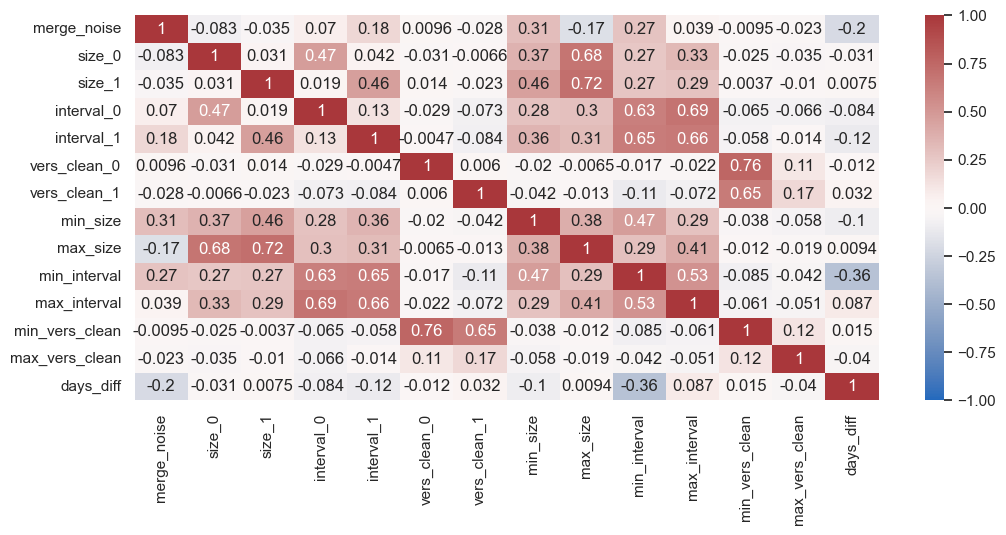

In [113]:
sns.heatmap(data=random_trial_data.corr(numeric_only=True), annot=True, vmin=-1, vmax=1, cmap='vlag')

From all the pairs which 
1. Both cookies have more instances than some threshold
2. Both cookies are lived more than somethreshold
3. Both cookies have version consistency more than some threshold  

What fraction have the the merging noise is less than some threshold?

In [114]:
features = ['min_size', 'min_interval', 'min_vers_clean']
target = 'merge_noise'

In [115]:
matrix = []
for s in range(1, 30):
    row = []
    for i in range(14):
        total_above_thresh = random_trial_data.loc[(random_trial_data[features] >= [s, i, 0.5]).all(axis=1)]
        good_aobve_thresh = total_above_thresh[total_above_thresh['merge_noise'] < noise_thresh]
        row.append(len(good_aobve_thresh)/len(total_above_thresh))
    matrix.append(row)

<AxesSubplot: >

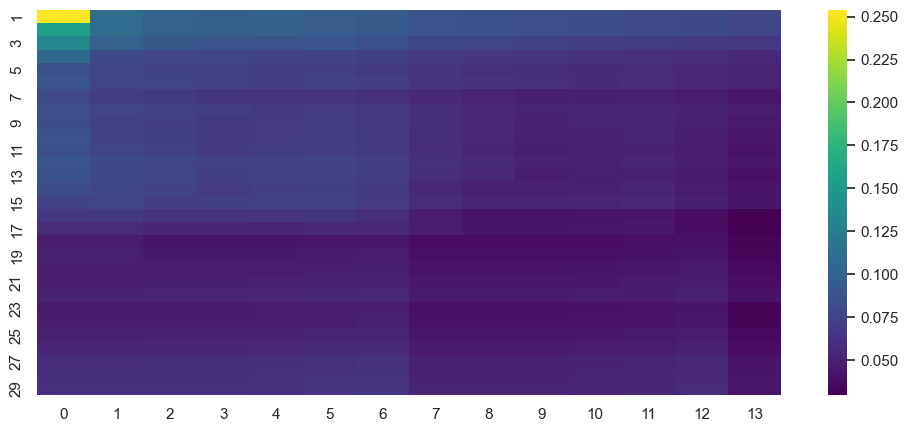

In [116]:
sns.heatmap(data=pd.DataFrame(matrix, columns=range(14), index=range(1,30)), 
            cmap='viridis')

#### Non-Random

In [117]:
more_than_one_cooke = filtered_data.groupby(const, observed=True).filter(lambda g: g['iiqid'].nunique() > 1)

In [118]:
def pick_two_random(group):
    return np.random.choice(group.unique(), size=2, replace=False)

pairs_series = more_than_one_cooke.groupby(const, observed=True)['iiqid'].agg(pick_two_random)

In [119]:
brothers_pairs = pd.DataFrame.from_dict(
        dict(zip(range(len(pairs_series)), pairs_series.values))).\
        transpose()
brothers_pairs.columns = ['first','second']

In [120]:
i = 3
iiqid_0, iiqid_1 = brothers_pairs.iloc[i].values
pair_data = more_than_one_cooke[((more_than_one_cooke['iiqid']==iiqid_0) 
                    | (more_than_one_cooke['iiqid']==iiqid_1))].copy()
pair_data.sort_values(by='time', inplace=True)
iiqid_0, iiqid_1
# iiqid_0_start, iiqid_1_start = pair_data.groupby('iiqid')['time'].agg('min').values
# print(iiqid_0_start, iiqid_1_start)
# pair_time_diff = abs(iiqid_0_start - iiqid_1_start)

('hYVQGjvJGM', 'JvxMvUw8UX')

In [121]:
noise_of_pairs2 = {'merge_noise': [], 'size_0': [], 'size_1': [], 'time_diff': [], 'first' : [], 'second': []}

for i in tqdm(brothers_pairs.index):
    iiqid_0, iiqid_1 = brothers_pairs.iloc[i].values
    pair_data = more_than_one_cooke[((more_than_one_cooke['iiqid']==iiqid_0) 
                        | (more_than_one_cooke['iiqid']==iiqid_1))].copy()
    pair_data.sort_values(by='time', inplace=True)
    iiqid_0_start, iiqid_1_start = pair_data.groupby('iiqid')['time'].agg('min').values
    pair_time_diff = abs(iiqid_0_start - iiqid_1_start)
    serialize_id = {iiqid_0: 0, iiqid_1: 1}
    
    s, inds = lnds(pair_data['iiqid'].apply(lambda x: serialize_id[x]).values)
    not_inds = [i for i in range(len(pair_data)) if i not in inds]
    
    noise_of_pairs2['merge_noise'].append(1 - len(s) / len(pair_data))
    noise_of_pairs2['size_0'].append(sum(pair_data['iiqid']==iiqid_0))
    noise_of_pairs2['size_1'].append(sum(pair_data['iiqid']==iiqid_1))
    noise_of_pairs2['time_diff'].append(pair_time_diff)    
    noise_of_pairs2['first'].append(iiqid_0)
    noise_of_pairs2['second'].append(iiqid_1)
noise_of_pairs_df2 = pd.DataFrame(noise_of_pairs2)

  0%|          | 0/1734 [00:00<?, ?it/s]

In [122]:
random_trial_data2 = noise_of_pairs_df2.merge(cookie_time, left_on='first', right_index=True)
random_trial_data2 = random_trial_data2.merge(cookie_time, left_on='second', right_index=True, 
                              suffixes=('_0', '_1'))

In [123]:
random_trial_data2 = random_trial_data2.merge(noises, left_on='first', right_index=True)
random_trial_data2 = random_trial_data2.merge(noises, left_on='second', right_index=True, 
                              suffixes=('_0', '_1'))

In [124]:
random_trial_data2['min_size'] = random_trial_data2[['size_0','size_1']].min(axis=1)
random_trial_data2['max_size'] = random_trial_data2[['size_0','size_1']].max(axis=1)

In [125]:
random_trial_data2 = random_trial_data2.rename(columns={'min_0': 'start_0', 'max_0': 'end_0',
                                  'min_1': 'start_1', 'max_1': 'end_1',
                                  'noise_0': 'vers_clean_0', 'noise_1': 'vers_clean_1'})

In [126]:
random_trial_data2['min_interval'] = random_trial_data2[['interval_0', 'interval_1']].min(axis=1)
random_trial_data2['max_interval'] = random_trial_data2[['interval_0', 'interval_1']].max(axis=1)

random_trial_data2['min_vers_clean'] = random_trial_data2[['vers_clean_0', 'vers_clean_1']].min(axis=1)
random_trial_data2['max_vers_clean'] = random_trial_data2[['vers_clean_0', 'vers_clean_1']].max(axis=1)

In [127]:
random_trial_data2['days_diff'] = random_trial_data2.time_diff.apply(lambda t: t.days)

In [128]:
random_trial_data2.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
merge_noise,1734.0,0.149353,0.151756,0.0,0.005946,0.103448,0.25,0.5
size_0,1734.0,28.214533,56.6886,1.0,2.0,9.0,29.0,1008.0
size_1,1734.0,28.6609,60.958731,1.0,2.0,9.0,30.0,1171.0
time_diff,1734,22 days 22:38:08.905779700,21 days 03:48:14.863326699,0 days 00:00:00.007000,5 days 06:19:32.403000,16 days 16:03:01.442000,35 days 20:41:58.901500,86 days 05:35:33.944000
interval_0,1734.0,24.032295,28.016031,0.0,0.0,11.0,43.0,87.0
interval_1,1734.0,25.66609,28.353995,0.0,0.0,15.0,48.0,88.0
vers_clean_0,1734.0,0.998814,0.011427,0.659091,1.0,1.0,1.0,1.0
vers_clean_1,1734.0,0.997878,0.019158,0.5,1.0,1.0,1.0,1.0
min_size,1734.0,11.122837,22.028503,1.0,1.0,3.0,11.0,371.0
max_size,1734.0,45.752595,76.449022,1.0,7.0,20.5,56.75,1171.0


In [129]:
# random_trial_data2.corr(numeric_only=True)['merge_noise'][1:].plot.bar()

<AxesSubplot: >

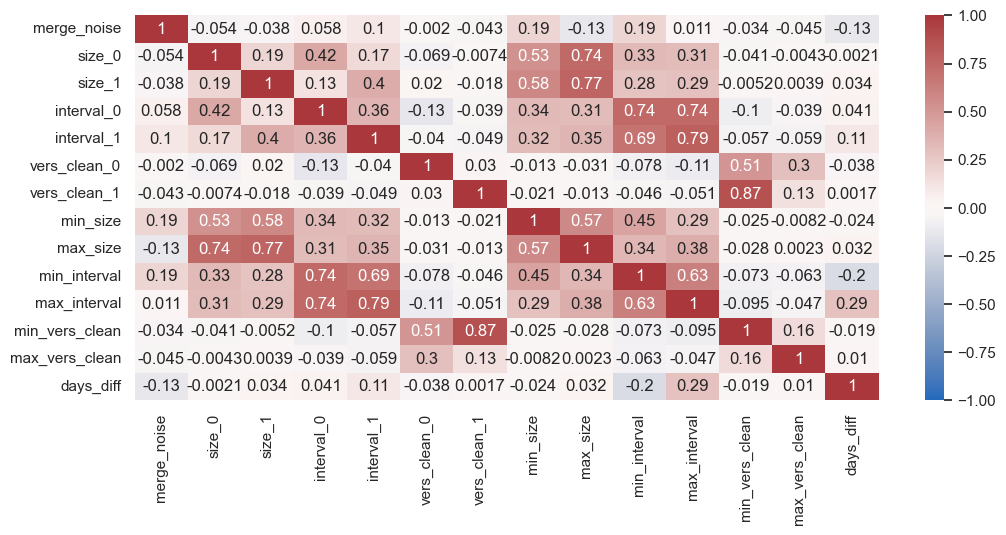

In [130]:
sns.heatmap(data=random_trial_data2.corr(numeric_only=True), annot=True, vmin=-1, vmax=1, cmap='vlag')

In [131]:
features = ['min_size', 'min_interval', 'min_vers_clean']
target = 'merge_noise'

In [132]:
matrix2 = []
for s in range(1, 30):
    row = []
    for i in range(14):
        total_above_thresh = random_trial_data2.loc[(random_trial_data2[features] >= [s, i, 0.5]).all(axis=1)]
        good_aobve_thresh = total_above_thresh[total_above_thresh['merge_noise'] < noise_thresh]
        row.append(len(good_aobve_thresh)/len(total_above_thresh))
    matrix2.append(row)

<AxesSubplot: >

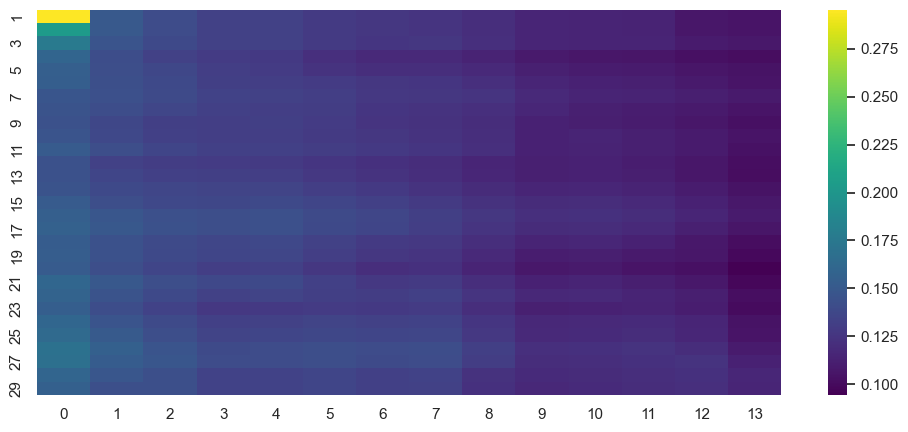

In [133]:
sns.heatmap(data=pd.DataFrame(matrix2, columns=range(14), index=range(1,30)), 
            cmap='viridis')

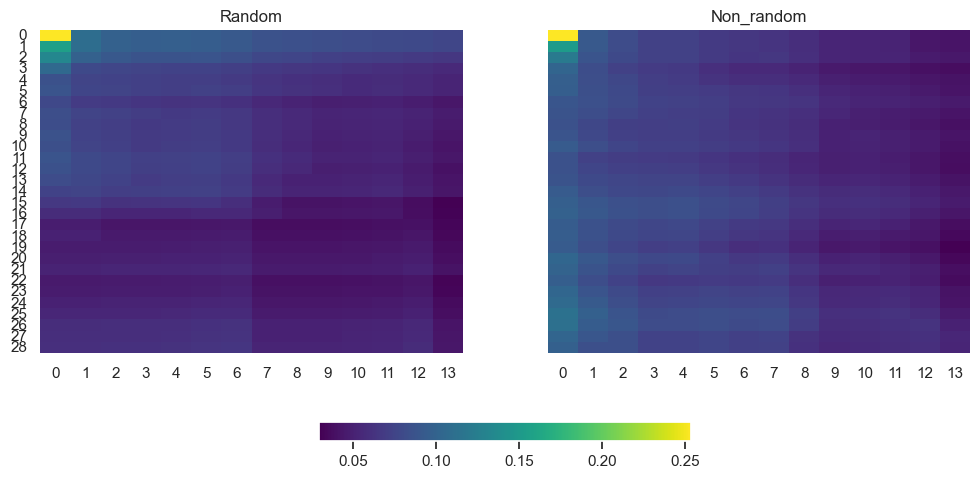

In [134]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

heatmap1 = sns.heatmap(matrix, cmap='viridis', ax=ax[0], cbar=False)
ax[0].set_title('Random')

heatmap2 = sns.heatmap(matrix2, cmap='viridis', ax=ax[1], cbar=False)
ax[1].set_title('Non_random')

# Add a shared colorbar to the plot
mappable = heatmap1.get_children()[0]
plt.colorbar(mappable, ax = ax,orientation = 'horizontal', shrink=0.4)

In [135]:
ratio_matrix = 1 - np.divide(matrix, matrix2)

<AxesSubplot: >

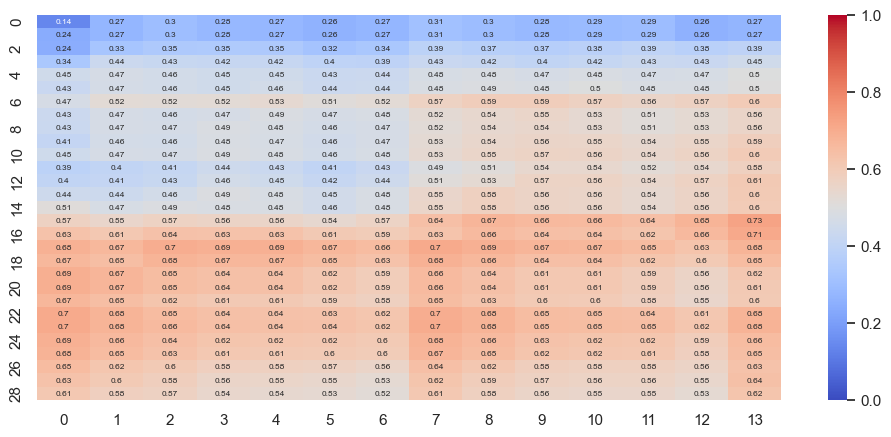

In [136]:
sns.heatmap(ratio_matrix, cmap='coolwarm', vmin=0, vmax=1, annot=True, annot_kws={'fontsize': 6})

#### GridSearch

In [137]:
# Define the ranges of parameter values to sample from
param_ranges = {
    'min_interval': np.arange(0, 14),
    'min_size': np.arange(1, 10),
    'min_vers_clean': np.linspace(0.5, 1, 10),
    'merge_noise': np.linspace(0, 0.2, 11)
}

# Set the number of random samples to generate
num_samples = 15000

# Initialize an empty dataframe to store the results
results_df = pd.DataFrame(columns=list(param_ranges.keys()) + ['random', 'non-random', 'difference', 'ratio'])

# Loop over all random samples of parameter values
for i in tqdm(range(num_samples)):
    # Sample random values for each parameter within the specified ranges
    param_values = {
        param_name: np.random.choice(param_range) for param_name, param_range in param_ranges.items()
    }
    
    # Apply the function to both dataframes with the current parameter values
    result1 = good_cookies_above_thresh(random_trial_data, **param_values)
    result2 = good_cookies_above_thresh(random_trial_data2, **param_values)
    
    # Compute the difference between the results
    difference = abs(result2 - result1)
    if result2 > 0:
        ratio = 1 - result1/result2
    else:
        ratio = 0.
    
    # Create a new dataframe with the current parameter values and the resulting difference
    row_df = pd.DataFrame({**param_values, 'random': result1, 'non-random': result2,
                           'difference': difference, 'ratio': ratio}, index=[0])
    
    # Concatenate the new dataframe to the results dataframe
    results_df = pd.concat([results_df, row_df], ignore_index=True)

  0%|          | 0/15000 [00:00<?, ?it/s]

In [138]:
results_df['min_interval'] = results_df['min_interval'].astype('int')
results_df['min_size'] = results_df['min_size'].astype('int')

In [139]:
results_df.sort_values(by='ratio', ascending=False).head(10)

,min_interval,min_size,min_vers_clean,merge_noise,random,non-random,difference,ratio
11425,13,7,0.500000,0.02,0.043478,0.108173,0.064695,0.598068
4937,13,7,0.611111,0.02,0.043478,0.108173,0.064695,0.598068
11947,13,7,0.555556,0.02,0.043478,0.108173,0.064695,0.598068
8224,13,7,0.888889,0.02,0.043860,0.107056,0.063196,0.590311
14891,13,7,0.888889,0.02,0.043860,0.107056,0.063196,0.590311
3648,9,7,0.833333,0.02,0.048583,0.118451,0.069868,0.589847
2363,9,7,0.777778,0.02,0.048583,0.118182,0.069599,0.588913
9927,9,7,0.777778,0.02,0.048583,0.118182,0.069599,0.588913
9760,8,7,0.833333,0.02,0.051587,0.125275,0.073687,0.588207
5762,9,7,0.500000,0.02,0.048583,0.117914,0.069331,0.587979


In [140]:
results_df[(results_df['min_size']<=7) 
           & (results_df['min_interval']<=7)].sort_values(by='ratio', ascending=False).head(10)

,min_interval,min_size,min_vers_clean,merge_noise,random,non-random,difference,ratio
10756,7,7,0.777778,0.02,0.054688,0.126609,0.071922,0.568061
6734,7,7,0.777778,0.02,0.054688,0.126609,0.071922,0.568061
730,7,7,0.611111,0.02,0.054688,0.126338,0.071651,0.567135
5307,7,7,0.666667,0.02,0.054688,0.126338,0.071651,0.567135
61,7,7,0.666667,0.02,0.054688,0.126338,0.071651,0.567135
9437,7,7,0.500000,0.02,0.054688,0.126338,0.071651,0.567135
4521,7,7,0.944444,0.02,0.056452,0.126915,0.070463,0.555200
9014,7,7,0.944444,0.02,0.056452,0.126915,0.070463,0.555200
10288,4,7,0.833333,0.02,0.062271,0.134000,0.071729,0.535291
12682,4,7,0.722222,0.02,0.062271,0.133466,0.071195,0.533432


<AxesSubplot: xlabel='non-random', ylabel='ratio'>

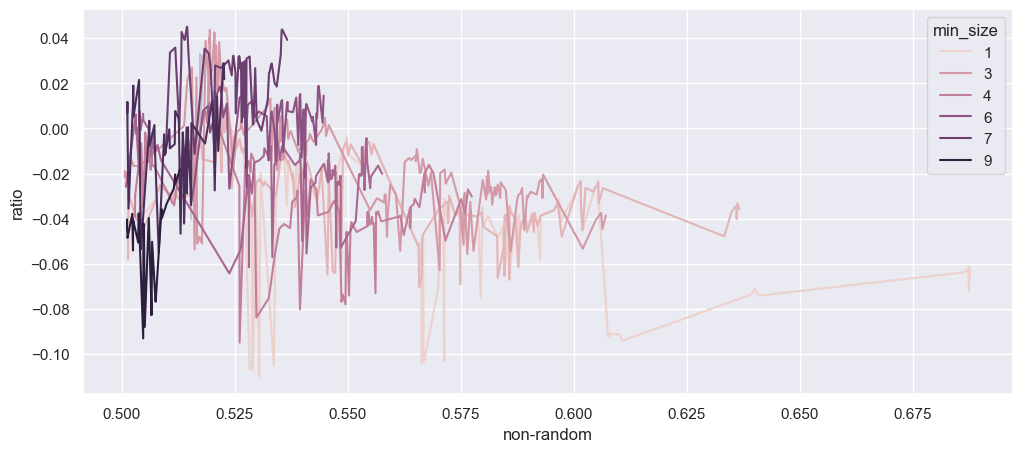

In [141]:
sns.lineplot(data=results_df.loc[results_df['non-random']>0.5], x='non-random', y='ratio', 
            hue='min_size')

In [142]:
cuts = results_df.copy()
cuts['non-random_cut'] = pd.cut(cuts.loc[cuts['non-random']>0.5, 'non-random'], 20)
cuts['nr_mid_cut'] = cuts['non-random_cut'].apply(lambda i:i.mid)

<AxesSubplot: xlabel='nr_mid_cut', ylabel='ratio'>

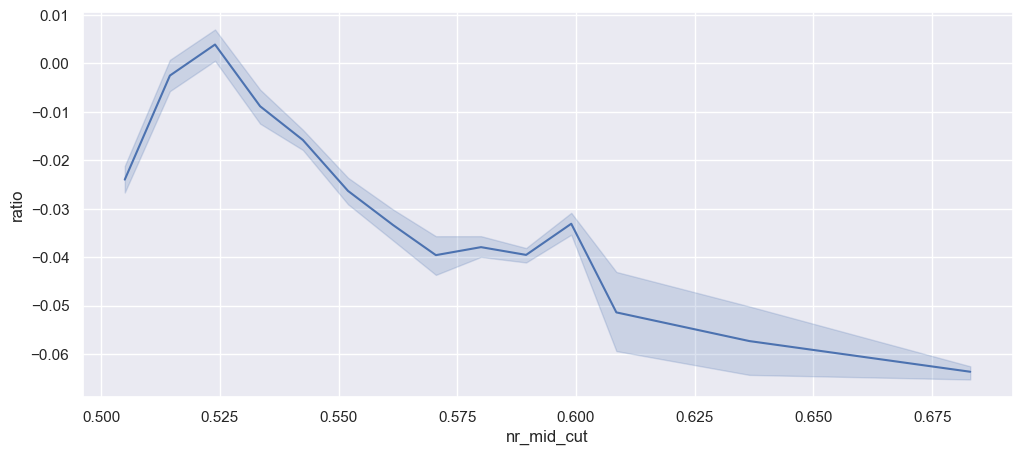

In [143]:
sns.lineplot(data=cuts, x='nr_mid_cut', y='ratio')#, hue='min_size')

<AxesSubplot: xlabel='min_size', ylabel='ratio'>

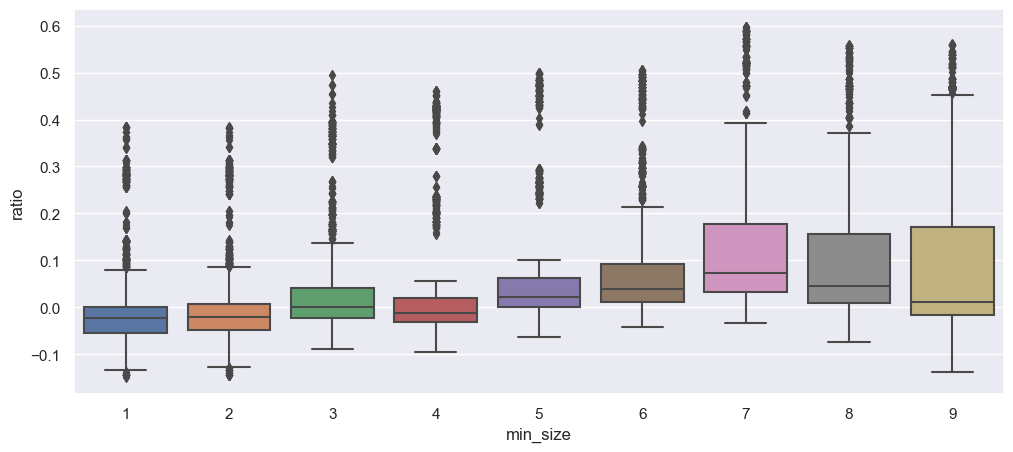

In [144]:
sns.boxplot(data=results_df, y='ratio', x='min_size')

## More features

- [X] Min interval
- [X] Max interval
- [X] Time between end first and start second (maybe after remove outliers)
- [ ] Time interval we looked at (can check options)
- [X] Min size
- [X] Max size
- [X] UA version error
- [X] Overlap errors that we calculate